<a href="https://colab.research.google.com/github/ekingit/CNN-for-CIFAR10/blob/main/CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Main libs
import time
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

#Torchvision
import torchvision
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision.transforms import v2

#Data

The CIFAR-10 dataset consists of 60,000 images in 10 classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 test images. Each image is a (3x32x32) tensor representing the Red, Green, and Blue (RGB) channels, along with a label ranging from 0 to 9 indicating the class.

In [2]:
#download the data and calculate the mean and standard deviation for all RGB channels for normalization
ds_train = torchvision.datasets.CIFAR10('./data', train=True, download=True) # 50.000 PIL.image
ds_test = torchvision.datasets.CIFAR10('./data', train=False, download=True)
ims_train = torch.tensor(ds_train.data) #tensor(50.000,32,32,3)
ims_train = ims_train.float() / 255. # tensor(50.000,32,32,3) -- 3x[0,1] RGB
mu=torch.mean(ims_train,[0,1,2]) # -> (3)
sigma=torch.std(ims_train,[0,1,2]) # -> (3)

100%|██████████| 170M/170M [00:03<00:00, 42.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


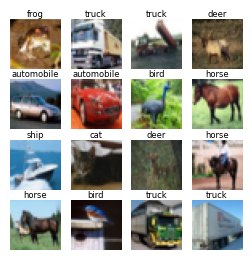

In [3]:
#looking at the data: 16 of 50.000 labeled pictures
labels = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
fig, ax = plt.subplots(4,4,figsize=(3,3))
for i, c_ax in enumerate(ax.flatten()):
    im, lab = ds_train[i]
    c_ax.imshow(im)
    c_ax.set_title(labels[lab],fontsize=6, y=0.88)
    c_ax.axis('off')

To improve model performance, we augment the training data by random cropping, horizontal flipping, and normalization. This helps in increasing the diversity of the training data and reducing overfitting.

In [4]:
#v2 transformations for data augmantation
v2_train = v2.Compose([
    v2.Pad(4),
    v2.RandomResizedCrop(size=(32, 32), antialias=True),
    v2.RandomHorizontalFlip(p=0.1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mu, sigma),
])
v2_test = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mu, sigma),
])

In [5]:
#data loaders:
ds_train_v2 = datasets.CIFAR10('./data', train=True, download=True, transform=v2_train)
ds_test_v2 = datasets.CIFAR10('./data', train=False, download=True, transform=v2_test)
dl_train = DataLoader(ds_train_v2, batch_size=128,shuffle=True) #50.000 item = 128*390.625 = 128*390+80
dl_test = DataLoader(ds_test_v2, batch_size=128,shuffle=True) #10.000 item = 128*78.125 = 128*78+16

Files already downloaded and verified
Files already downloaded and verified


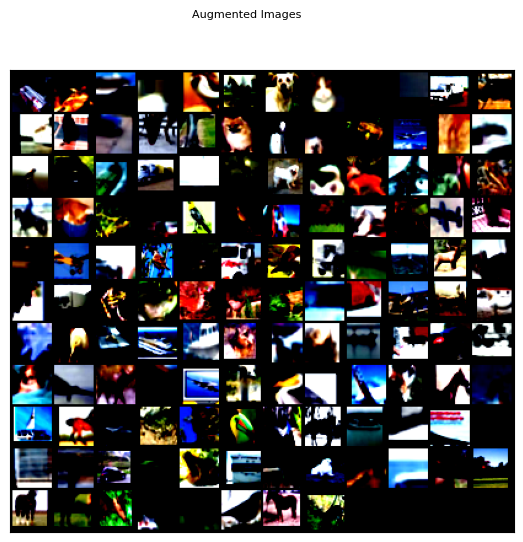

In [6]:
# looking at the data after the augmentation
for images, labels in dl_train:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=12).permute(1,2,0))
    fig.suptitle('Augmented Images', fontsize=8)
    break

#Model

We design and implement a CNN model from scratch, inspired by the VGG16 architecture. Below is a summary of the model's structure:"

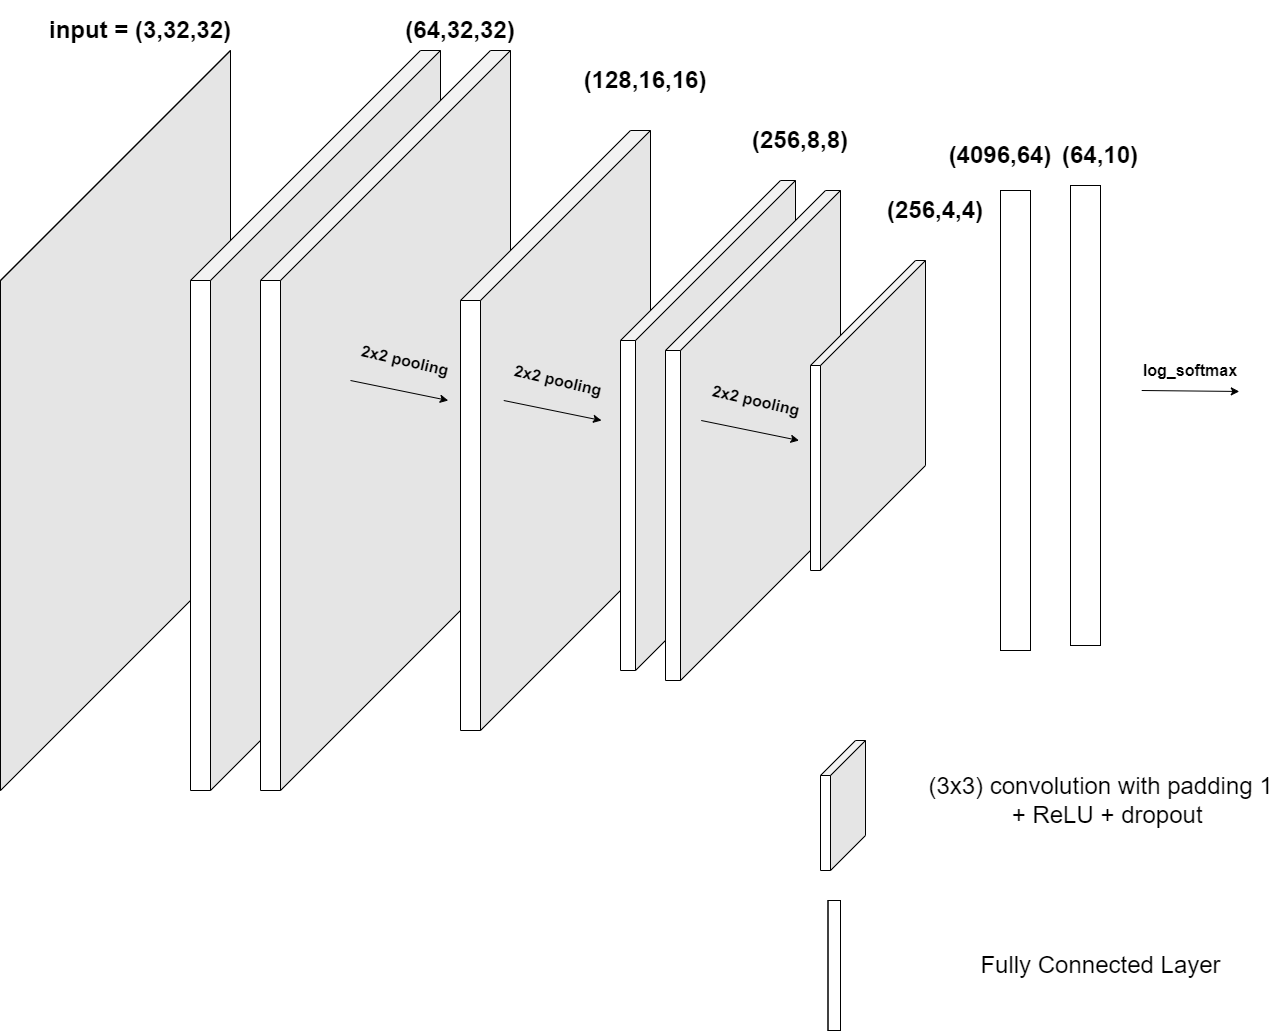

In [7]:
class CNN(nn.Module): #(batch_size=128,3,32,32) --> (batch_size,10)
    def __init__(self):
        super(CNN, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2) # (A,B,C,C)-> (A,B,C/2,C/2)
        self.act = nn.ReLU() # tens -> tens
        self.drop = nn.Dropout(0.1) # tens -> tens

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding=1)   # (128,3,A,A)  --> (128,64,A,A)
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1)  # (128,64,A,A) --> (128,64,A,A)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)  # (128,64,A,A) --> (128,128,A,A)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1)  # (128,128,A,A) --> (128,128,A,A)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1) # (128,128,A,A) --> (128,256,A,A)
        self.conv6 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1) # (128,256,A,A) --> (128,256,A,A)

        self.lp1 = nn.Linear(4096,128) # (128,4096) --> (128,128)
        self.lp2 = nn.Linear(128,10)   #  (128,128) --> (128,10)

    def forward(self, X):
        X = self.drop(self.act(self.conv1(X))) #(128,3,32,32) --> (128,64,32,32)
        X = self.drop(self.act(self.pool(self.conv2(X)))) #(128,64,32,32) --> (128,64,16,16)
        X = self.drop(self.act(self.pool(self.conv3(X)))) #(128,64,16,16) --> (128,128,8,8)
        X = self.drop(self.act(self.conv4(X))) # (128,128,8,8) --> (128,128,8,8)
        X = self.drop(self.act(self.pool(self.conv5(X)))) #(128,128,8,8) --> (128,256,4,4)
        X = self.drop(self.act(self.conv6(X))) # (128,256,4,4) --> (128,256,4,4)
        X = torch.flatten(X,1) # (128,128,4,4) --> (128, 4096)
        X = self.drop(self.act(self.lp1(X))) # --> (4096,64)
        X = F.log_softmax(self.lp2(X),dim=1) # --> (128,10)
        return X # softmax normalizes X \in R^10, log returns a negative value

In [8]:
model = CNN()
total_parameters = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_parameters:,}")

Total Parameters: 1,671,114


In [9]:
def train(model, dl, optimizer, epoch, device='cpu'):
    model.to(device)
    model.train()
    correct = 0
    train_loss = 0
    for data, target in dl:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data) #(batch_size,3,32,32) --> (10)
        batch_loss = F.nll_loss(output, target) #(10x10) --> 1
        batch_loss.backward() #calculates gradients
        optimizer.step() #updates weights and kernels
        train_loss += batch_loss.detach().item()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item() # get the correct predictions

    correct = 100. * correct / len(dl.dataset)
    train_loss /= len(dl)

    print(f'Epoch: {epoch}, Avarage train loss: {train_loss:.2f}, Accuracy: {correct:.1f}%')
    return train_loss, correct

In [10]:
def test(model, dl_test, device='cpu'):
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # no need to track gradients. Saves memory.
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            batch_loss = F.nll_loss(output,target)
            test_loss += batch_loss.detach().item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # get the correct predictions

    test_loss /= len(dl_test)
    correct = 100. * correct / len(dl_test.dataset)
    print(f'Avarage test loss: {test_loss:.2f}, Accuracy: {correct:.1f}%')
    return test_loss, correct

#Train

In [11]:
torch.manual_seed(4321) #fixes initial weights and kernels to test different models/hyperparameters

device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up

model = CNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9,
weight_decay=5e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [12]:
# run()
a = time.time()
trainloss, testloss, trainacc, testacc = [], [], [], []
epochs = 70
best_acc = 0
for epoch in range(0, epochs):
    train_loss, train_acc = train(model, dl_train, optimizer, epoch+1, device=device)
    trainloss.append(train_loss)
    trainacc.append(train_acc)
    test_loss, test_acc = test(model, dl_test, device=device)
    testloss.append(test_loss)
    testacc.append(test_acc)
    if test_acc > best_acc:
        best_acc = test_acc
        best_train_acc = train_acc
        best_epoch = epoch
        #torch.save(best_model.state_dict(), '.../best_model.pth')
    scheduler.step()
b = time.time()
print(f'Training took {round(b - a, 0)} seconds.')
print(f'Best test accuracy: {best_acc}, with corresponding training accuracy: {best_train_acc}, achieved at epoch: {best_epoch}, using T4-GPU')

Epoch: 1, Avarage train loss: 2.20, Accuracy: 15.9%
Avarage test loss: 1.99, Accuracy: 25.7%
Epoch: 2, Avarage train loss: 1.96, Accuracy: 26.0%
Avarage test loss: 1.76, Accuracy: 36.7%
Epoch: 3, Avarage train loss: 1.82, Accuracy: 32.1%
Avarage test loss: 1.64, Accuracy: 39.1%
Epoch: 4, Avarage train loss: 1.70, Accuracy: 36.9%
Avarage test loss: 1.46, Accuracy: 45.8%
Epoch: 5, Avarage train loss: 1.61, Accuracy: 40.1%
Avarage test loss: 1.39, Accuracy: 48.4%
Epoch: 6, Avarage train loss: 1.52, Accuracy: 44.2%
Avarage test loss: 1.28, Accuracy: 52.9%
Epoch: 7, Avarage train loss: 1.45, Accuracy: 46.8%
Avarage test loss: 1.17, Accuracy: 57.5%
Epoch: 8, Avarage train loss: 1.36, Accuracy: 50.2%
Avarage test loss: 1.07, Accuracy: 61.3%
Epoch: 9, Avarage train loss: 1.29, Accuracy: 53.2%
Avarage test loss: 1.18, Accuracy: 59.2%
Epoch: 10, Avarage train loss: 1.22, Accuracy: 56.2%
Avarage test loss: 1.00, Accuracy: 64.6%
Epoch: 11, Avarage train loss: 1.16, Accuracy: 58.1%
Avarage test los

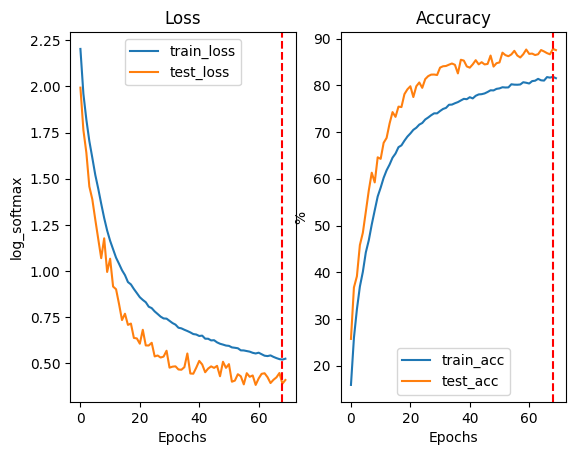

In [13]:
plt.subplot(1,2,1)
plt.plot(trainloss, label='train_loss')
plt.plot(testloss, label='test_loss')
plt.title('Loss')
plt.ylabel('log_softmax')
plt.xlabel('Epochs')
plt.axvline(x=best_epoch, color='r', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trainacc, label='train_acc')
plt.plot(testacc,label='test_acc')
plt.title('Accuracy')
plt.ylabel('%')
plt.xlabel('Epochs')
plt.rcParams["figure.figsize"] = (15,6)
plt.axvline(x=best_epoch, color='r', linestyle='--')
plt.legend()
plt.show()

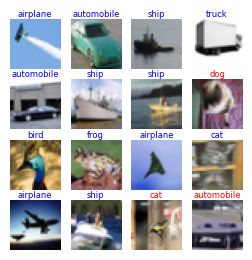

In [14]:
#looking at the predictions: red indicates incorrect predictions, while blue represents correct ones.
labels = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
rand = torch.randint(10000,(16,1))
fig, ax = plt.subplots(4,4,figsize=(3,3))
for i, c_ax in enumerate(ax.flatten()):
    ex_num = rand[i].item()
    var1 = ds_test_v2[ex_num][0].reshape(1,3,32,32).to(device) #augmented images
    var2 = (ds_test[ex_num][0]) #original images
    im = (ds_test_v2[ex_num][1]) #correct labels
    pred = model(var1) #probabilistic predictions
    pred_label = pred.argmax(dim=1, keepdim=True).item() #prediction
    if ds_test_v2[ex_num][1] == pred_label:
        c_ax.set_title((labels[pred_label]), fontsize=6,color='blue', y=0.88)
    else:
        c_ax.set_title(labels[pred_label],fontsize=6,color='red', y=0.88)
    c_ax.imshow(var2)
    c_ax.axis('off')